# DSCI-100 Group 003-18 Project Report

## Introduction

The provided dataset from `PLAICRAFT` contains information from a research group's `Minecraft` server. This server was created to study the behaviour of players and "create an advanced artificial intelligence (AI) that not only understands speech but can also respond and act within a complex virtual environment." (Quote: [plaicraft.ai](https://plaicraft.ai/))

For this specific project, the research group is interested in recruiting more players to gather additional data. They have provided our class with some data and 3 broad questions to help them understand which players to target for recruitment. For our project, we aim to answer the following question:

> Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

In more specific terms of the predictors we will be using, we answer the question:

> Can the player's own Experience, Played Hours, Gender and Age predict whether the player will subscribe to the game newsletter?

We are using the `players.csv` dataset for our analysis. Let us first load the `tidyverse` R library and load the dataset:

In [1]:
library(tidyverse)
players <- read_csv("https://raw.githubusercontent.com/Alexjhz07/DSCI-100-Project-Individual/refs/heads/main/players.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Methods & Results:

We will employ Logistic Regression to model the probability of subscription (our binary dependent variable) based on key player attributes sourced from the `players.csv` dataset. Before conducting any analysis, we first performed minimal yet essential data cleaning steps to ensure the dataset was suitable for modelling：

1. Removed players who recorded `played_hours = 0`, since they did not engage with the game.
2. Removed rows with missing age, as age is one of our planned predictors.
3. Converted `subscribe` into a factor with levels `"no"` and `"yes"` to improve clarity and interpretability in later modelling, as these labels are easier to work with than logical TRUE/FALSE values.
4. Treated `experience` and `gender` as categorical variables.

In [2]:
players_clean <- players |>
  filter(played_hours > 0) |>
  filter(!is.na(Age)) |>
  mutate(
    subscribe = if_else(subscribe, "yes", "no"),
    subscribe = factor(subscribe, levels = c("no", "yes")),
    experience = factor(experience),
    gender = factor(gender)
  )

summary(players_clean)



    experience subscribe hashedEmail         played_hours        name          
 Amateur :35   no :25    Length:109         Min.   :  0.10   Length:109        
 Beginner:19   yes:84    Class :character   1st Qu.:  0.10   Class :character  
 Pro     :10             Mode  :character   Median :  0.50   Mode  :character  
 Regular :19                                Mean   : 10.51                     
 Veteran :26                                3rd Qu.:  1.80                     
                                            Max.   :223.10                     
               gender        Age      
 Agender          : 1   Min.   : 9.0  
 Female           :21   1st Qu.:17.0  
 Male             :75   Median :20.0  
 Non-binary       : 6   Mean   :21.3  
 Prefer not to say: 5   3rd Qu.:23.0  
 Two-Spirited     : 1   Max.   :58.0  

### Initial Summary Statistics

To gain an initial understanding of the cleaned dataset, we computed basic summary statistics for key variables. These provide a general overview of player demographics and behaviours before conducting more detailed analyses.

In [3]:
players_clean |>
  summarise(
    n_players = n(),
    mean_age = mean(Age),
    median_age = median(Age),
    mean_hours = mean(played_hours),
    median_hours = median(played_hours),
    subscription_rate = mean(subscribe == "yes")
  )

n_players,mean_age,median_age,mean_hours,median_hours,subscription_rate
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,21.30275,20,10.50917,0.5,0.7706422


### Figure 1: Distribution of Played Hours by Subscription Status (Log Scale)

To visualize differences in gameplay behaviour between subscribed and non-subscribed players, we use a jitter plot with a logarithmic y-axis. The log scale helps separate high-hour players from low-hour players, making the distribution easier to interpret for this highly right-skewed variable.

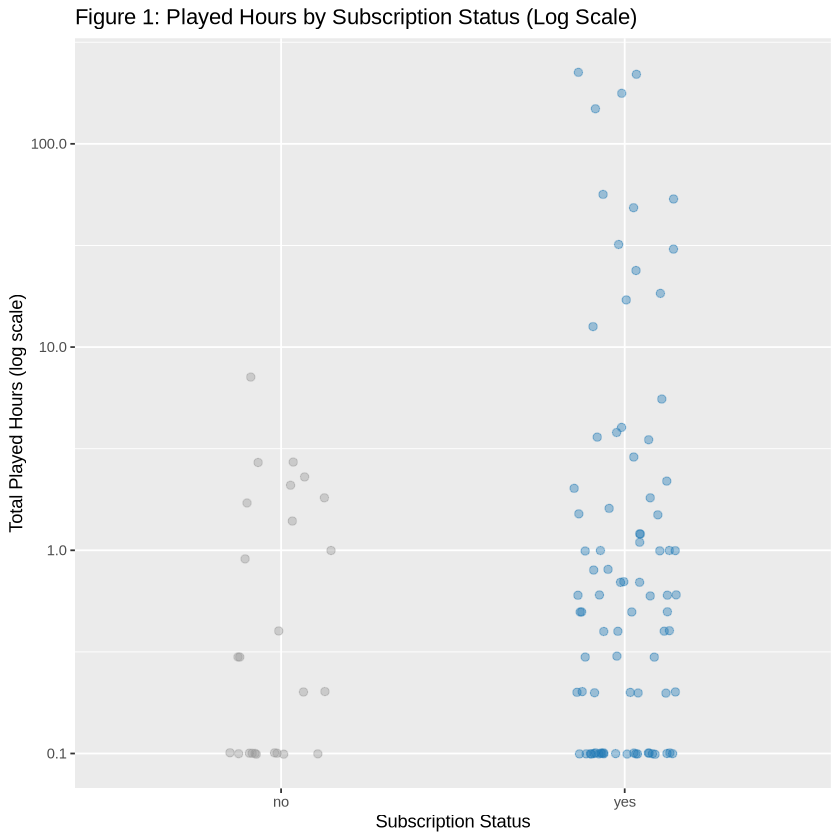

In [4]:
ggplot(players_clean, aes(x = subscribe, y = played_hours, color = subscribe)) +
  geom_jitter(alpha = 0.4, width = 0.15, size = 2) +
  scale_y_log10() +
  scale_color_manual(values = c("no" = "#999999", "yes" = "#1f78b4")) +
  labs(
    title = "Figure 1: Played Hours by Subscription Status (Log Scale)",
    x = "Subscription Status",
    y = "Total Played Hours (log scale)"
  ) +
  theme(legend.position = "none")

**Figure 1 Summary.**  
Players who subscribe tend to have substantially higher total played hours than non-subscribers. Most non-subscribed players cluster at very low playtime levels, whereas subscribed players are more widely distributed and include almost all high-hour players. This suggests that gameplay engagement is strongly associated with newsletter subscription.

### Figure 2: Subscription Rates Across Experience Levels

To further explore behavioural differences between player types, we examined how subscription rates vary across self-reported experience levels. 
This visualization highlights whether more experienced players are more likely to subscribe to the newsletter.

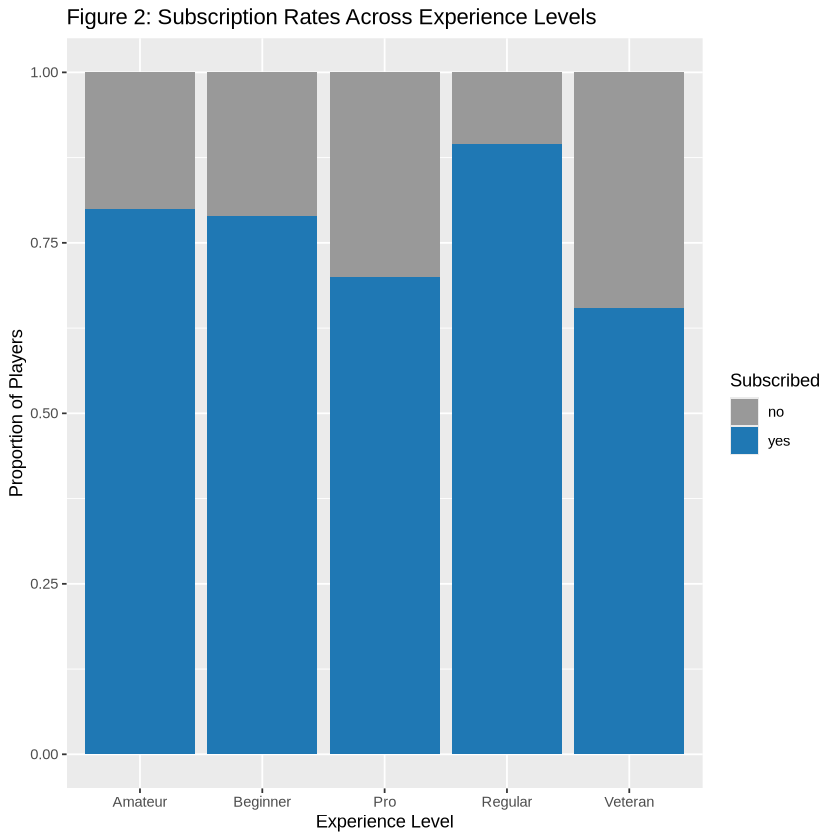

In [5]:
ggplot(players_clean, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_fill_manual(values = c("no" = "#999999", "yes" = "#1f78b4")) +
  labs(
    title = "Figure 2: Subscription Rates Across Experience Levels",
    x = "Experience Level",
    y = "Proportion of Players",
    fill = "Subscribed"
  )

**Figure 2 Summary.**  
Subscription behaviour differs moderately across experience levels. Regular players show the highest subscription rate, followed by Amateur and Beginner players with mid-range rates. Veteran and Pro players exhibit noticeably lower subscription rates. Although the differences are not dramatic, this pattern suggests that newsletter engagement peaks among mid-experience players rather than complete novices or the most advanced users.

### Comparison of Subscription Rate by Experience and Age Group

age_group,n,subscription_rate
<fct>,<int>,<dbl>
≤15,6,1.0000000
16–20,48,0.7291667
21–25,38,0.8421053
26–30,8,0.7500000
31+,9,0.5555556


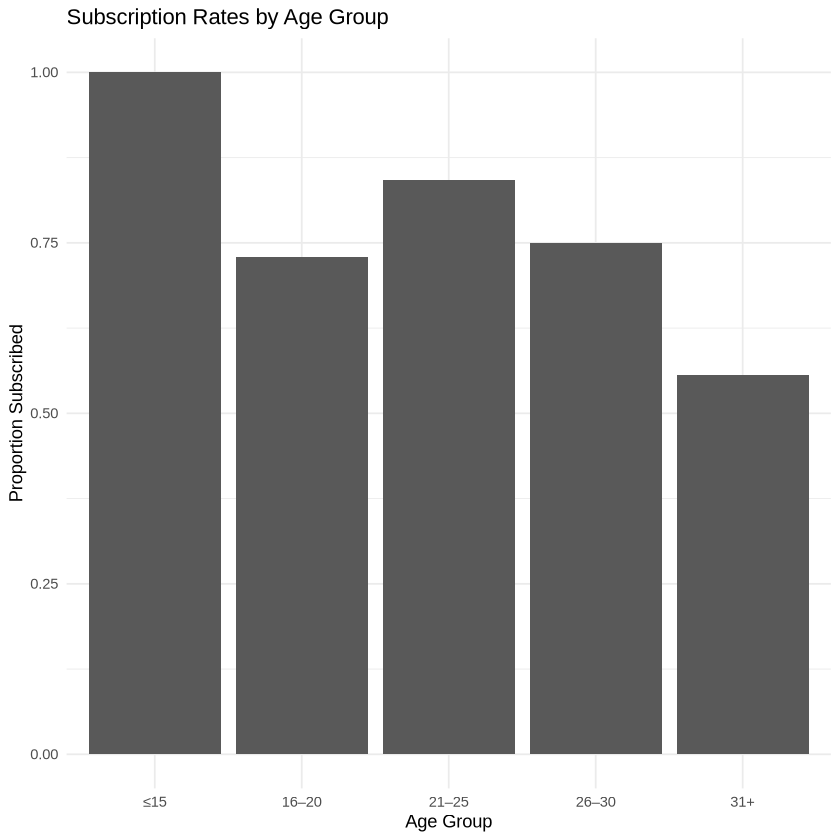

In [6]:
players_age_groups <- players_clean |>
  mutate(
    age_group = cut(
      Age,
      breaks = c(0, 15, 20, 25, 30, Inf),
      labels = c("≤15", "16–20", "21–25", "26–30", "31+"),
      right = FALSE
    )
  )

age_summary <- players_age_groups |>
  group_by(age_group) |>
  summarise(
    n = n(),
    subscription_rate = mean(subscribe == "yes"),
    .groups = "drop"
  )

age_summary

ggplot(age_summary,
       aes(x = age_group, y = subscription_rate)) +
  geom_col() +
  labs(
    title = "Subscription Rates by Age Group",
    x = "Age Group",
    y = "Proportion Subscribed"
  ) +
  theme_minimal()

### The chart shows a comparsion of the subscription rate by age Group.
+ This diagram shows that Younger players have the higher subscription rates across most age groups, suggesting that younger players are the most engaged with community content like newsletters.
+ Younger players (≤15) show strong subscription interest, though this may not be fully reflected in the true population as our sample size for younger players in this age range is small.

### Comparison of the Combined Engagement Score (Played Hours)

experience,mean_hours,median_hours,max_hours
<fct>,<dbl>,<dbl>,<dbl>
Amateur,10.831429,0.50,150.0
Beginner,2.300000,0.80,23.7
Pro,3.620000,0.55,30.3
Regular,34.494737,0.60,223.1
Veteran,1.196154,0.15,12.5


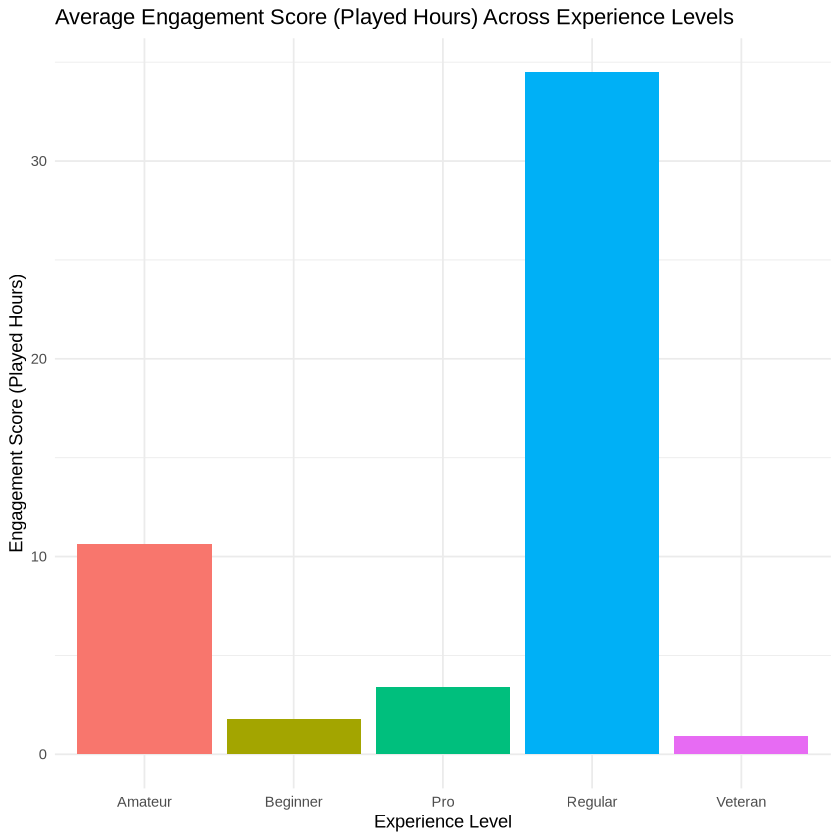

In [7]:
hours_experience_summary <- players_clean |>
  group_by(experience) |>
  summarise(
    mean_hours = mean(played_hours),
    median_hours = median(played_hours),
    max_hours = max(played_hours),
    .groups = "drop"
  )

hours_experience_summary

players_clean_engagement <- players_clean |>
  mutate(engagement_score = played_hours * if_else(subscribe == "yes", 1, 0))

engagement_summary <- players_clean_engagement |>
  group_by(experience) |>
  summarise(
    mean_engagement = mean(engagement_score),
    .groups = "drop"
  )

ggplot(engagement_summary,
       aes(x = experience, y = mean_engagement, fill = experience)) +
  geom_col() +
  labs(
    title = "Average Engagement Score (Played Hours) Across Experience Levels",
    x = "Experience Level",
    y = "Engagement Score (Played Hours)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

### The Diagram of the Total Hours Comparison Across Experience Groups.
+ The graph shows that Regular players spend significantly more time playing compared to all other experience levels, with both the highest mean (34.5 hours) and the widest range of playtime (up to 223 hours).
+ Although Amateur players also show moderate playtime (mean ~10.8 hours), their hours are much more concentrated and lower in variability.
+ Pro players do not necessarily spend more time than Beginners, indicating that higher skill does not always reflect higher engagement time.
+ Veteran players record the lowest average and median hours, suggesting that long-term familiarity with the game might reduce total engagement.
+ The results reveal that mid-experience (Regular) players are the most active, while Beginners and Veterans tend to have lower total playtime.

### Data Preparation and Cleaning

In [8]:
players_model <- players |>
  select(experience, subscribe, played_hours, Age, gender) |>
  drop_na(experience, subscribe, played_hours, Age, gender) |>
  mutate(
    subscribe = factor(if_else(subscribe, "Yes", "No"),
                       levels = c("No", "Yes")),
    experience = factor(experience,
                        levels = c("Beginner", "Amateur", "Regular",
                                   "Veteran", "Pro")),
    gender3 = case_when(
      gender == "Male"   ~ "Male",
      gender == "Female" ~ "Female",
      TRUE               ~ "Other"
    ),
    gender3 = factor(gender3, levels = c("Male", "Female", "Other"))
  )

players_model |> group_by(gender) |> summarise(count = n())

head(players_model)

gender,count
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Prefer not to say,11
Two-Spirited,5


experience,subscribe,played_hours,Age,gender,gender3
<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
Pro,Yes,30.3,9,Male,Male
Veteran,Yes,3.8,17,Male,Male
Veteran,No,0.0,17,Male,Male
Amateur,Yes,0.7,21,Female,Female
Regular,Yes,0.1,21,Male,Male
Amateur,Yes,0.0,17,Female,Female


We grouped the Genders into 3 groups consisting of `Male`, `Female`, and `Other` as the `Agender` and other groups did not have sufficient data for us to work well with considering how many other factors we plan on using during the training.

### Logistic Regression Model

In [9]:
log_model <- glm(
  subscribe ~ experience + played_hours + Age + gender3,
  data = players_model,
  family = binomial
)
summary(log_model)


Call:
glm(formula = subscribe ~ experience + played_hours + Age + gender3, 
    family = binomial, data = players_model)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        2.63326    0.69717   3.777 0.000159 ***
experienceAmateur -0.35721    0.51705  -0.691 0.489646    
experienceRegular  0.16212    0.62928   0.258 0.796690    
experienceVeteran -0.34474    0.53929  -0.639 0.522670    
experiencePro     -0.68990    0.77721  -0.888 0.374718    
played_hours       0.11282    0.08483   1.330 0.183554    
Age               -0.06680    0.02351  -2.842 0.004489 ** 
gender3Female      0.19465    0.49178   0.396 0.692243    
gender3Other      -0.64581    0.43370  -1.489 0.136468    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 225.54  on 193  degrees of freedom
Residual deviance: 205.49  on 185  degrees of freedom
AIC: 223.49

Number of Fisher Scoring i

### Converting Coefficients to Odds Ratios

In [10]:
exp(coef(log_model))

(Intercept) experienceAmateur experienceRegular experienceVeteran 
       13.9190766         0.6996225         1.1760069         0.7084072 
    experiencePro      played_hours               Age     gender3Female 
        0.5016239         1.1194268         0.9353862         1.2148882 
     gender3Other 
        0.5242379

### Interpreting Predictor Effects

After converting the logistic regression coefficients into odds ratios, we can interpret how each predictor influences the likelihood of subscribing to the newsletter. The odds ratio for `played_hours` is about **1.12**, meaning that for every additional hour a player spends on the server, the odds of subscribing increase by roughly **12%**, holding all other variables constant. This confirms that engagement level is the strongest predictor in the model.

For experience, the effects are smaller. Compared to `Beginners` (The baseline group), `Amateur` (0.70) and `Pro` players (0.50) have slightly lower odds of subscribing, while `Regular` players (1.18) have slightly higher odds. However, these values are all close to 1, suggesting that experience level alone has only a modest effect once playtime is accounted for.

`age` also has an odds ratio close to 1 (0.94), indicating that age has a weak and slightly negative relationship with subscription. Gender differences are also small: `Female` players have odds about **1.21×** those of `Male` (The baseline group), while players in the `Other` have odds of about **0.52×**. These differences are relatively minor compared to the strong influence of playtime.

Overall, the odds ratios show that `played_hours` is the **main** driver of newsletter subscription, while `experience`, `age`, and `gender` play much smaller roles.

### Probability Plots

For our predicted-probability plots, we want to see the effects of one variable changing while keeping everything else constant. To achieve this, we're going to predict over some new generated datasets that cover the range of possible values for each quantitative variable, and draw separate lines for each categorical variable pairing. For the quantitative variables that are not the primary focus of a plot, we will instead set the value to the mean average to keep things consistent. Let's complete the new datasets below:



In [11]:
varying_age_data <- expand.grid(
    Age = seq(min(players_model$Age), max(players_model$Age)),
    experience = levels(players_model$experience),
    gender3 = levels(players_model$gender3),
    played_hours = mean(players_model$played_hours)
)

head(varying_age_data)
summary(varying_age_data)

varying_hours_data <- expand.grid(
    Age = mean(players_model$Age),
    experience = levels(players_model$experience),
    gender3 = levels(players_model$gender3),
    played_hours = seq(min(players_model$played_hours), max(players_model$played_hours))
)

head(varying_hours_data)
summary(varying_hours_data)

,Age,experience,gender3,played_hours
,<int>,<fct>,<fct>,<dbl>
1,9,Beginner,Male,5.904639
2,10,Beginner,Male,5.904639
3,11,Beginner,Male,5.904639
4,12,Beginner,Male,5.904639
5,13,Beginner,Male,5.904639
6,14,Beginner,Male,5.904639


      Age          experience    gender3     played_hours  
 Min.   : 9.0   Beginner:150   Male  :250   Min.   :5.905  
 1st Qu.:21.0   Amateur :150   Female:250   1st Qu.:5.905  
 Median :33.5   Regular :150   Other :250   Median :5.905  
 Mean   :33.5   Veteran :150                Mean   :5.905  
 3rd Qu.:46.0   Pro     :150                3rd Qu.:5.905  
 Max.   :58.0                               Max.   :5.905  

,Age,experience,gender3,played_hours
,<dbl>,<fct>,<fct>,<int>
1,21.13918,Beginner,Male,0
2,21.13918,Amateur,Male,0
3,21.13918,Regular,Male,0
4,21.13918,Veteran,Male,0
5,21.13918,Pro,Male,0
6,21.13918,Beginner,Female,0


      Age           experience    gender3      played_hours   
 Min.   :21.14   Beginner:672   Male  :1120   Min.   :  0.00  
 1st Qu.:21.14   Amateur :672   Female:1120   1st Qu.: 55.75  
 Median :21.14   Regular :672   Other :1120   Median :111.50  
 Mean   :21.14   Veteran :672                 Mean   :111.50  
 3rd Qu.:21.14   Pro     :672                 3rd Qu.:167.25  
 Max.   :21.14                                Max.   :223.00  

Now that we have these datasets, let's first perform the prediction on the Age dataset and plot the results to see how our predictions change as we change one quantitative variable while keeping everything else fixed: (Per categorical variable combination)

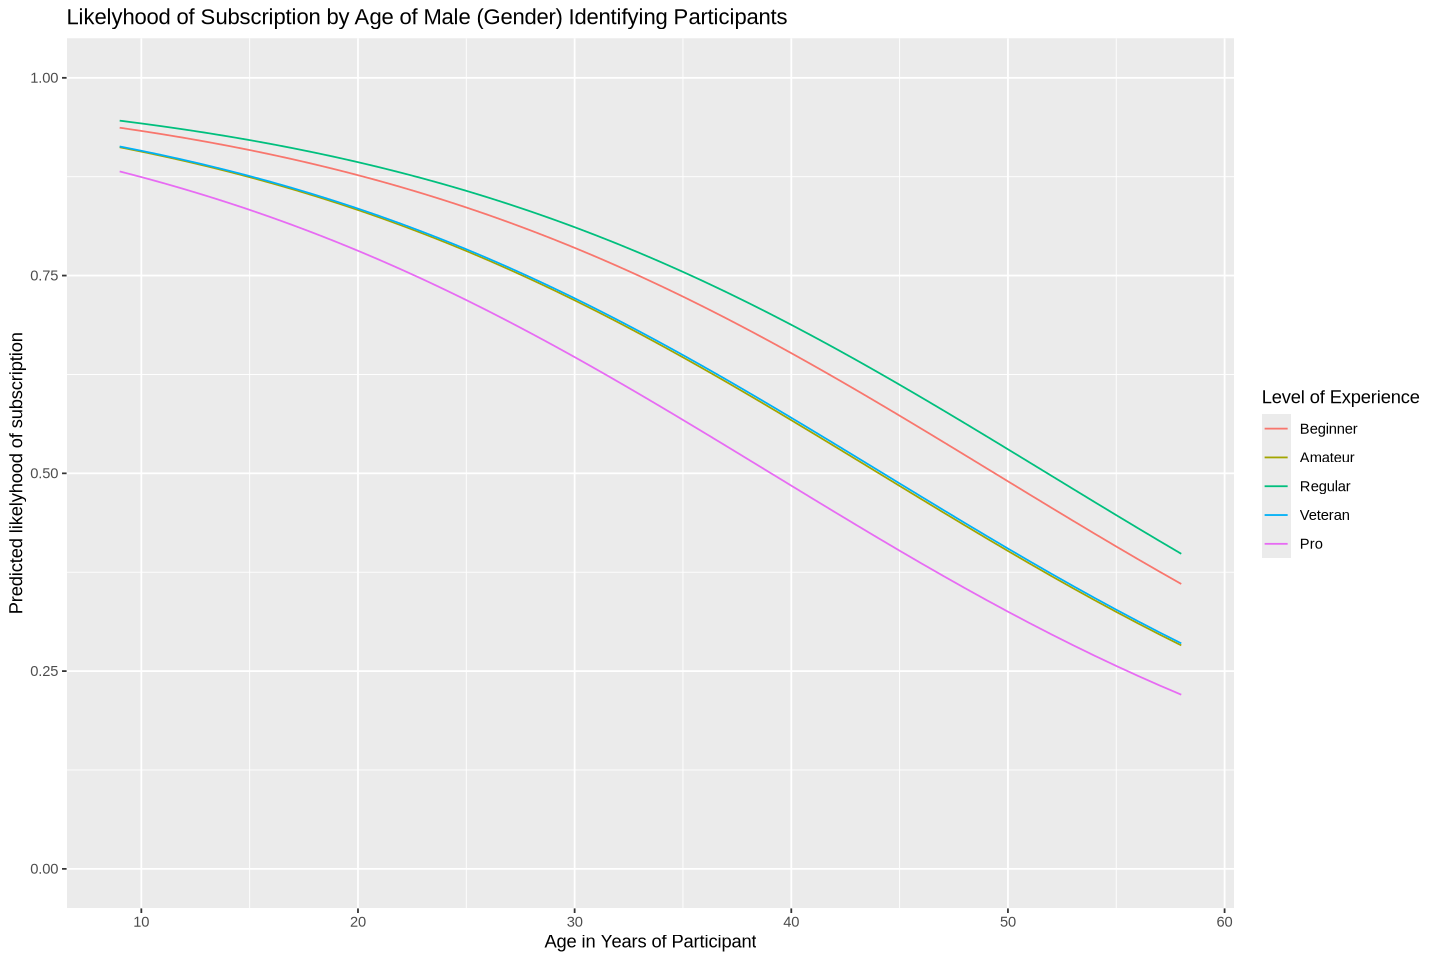

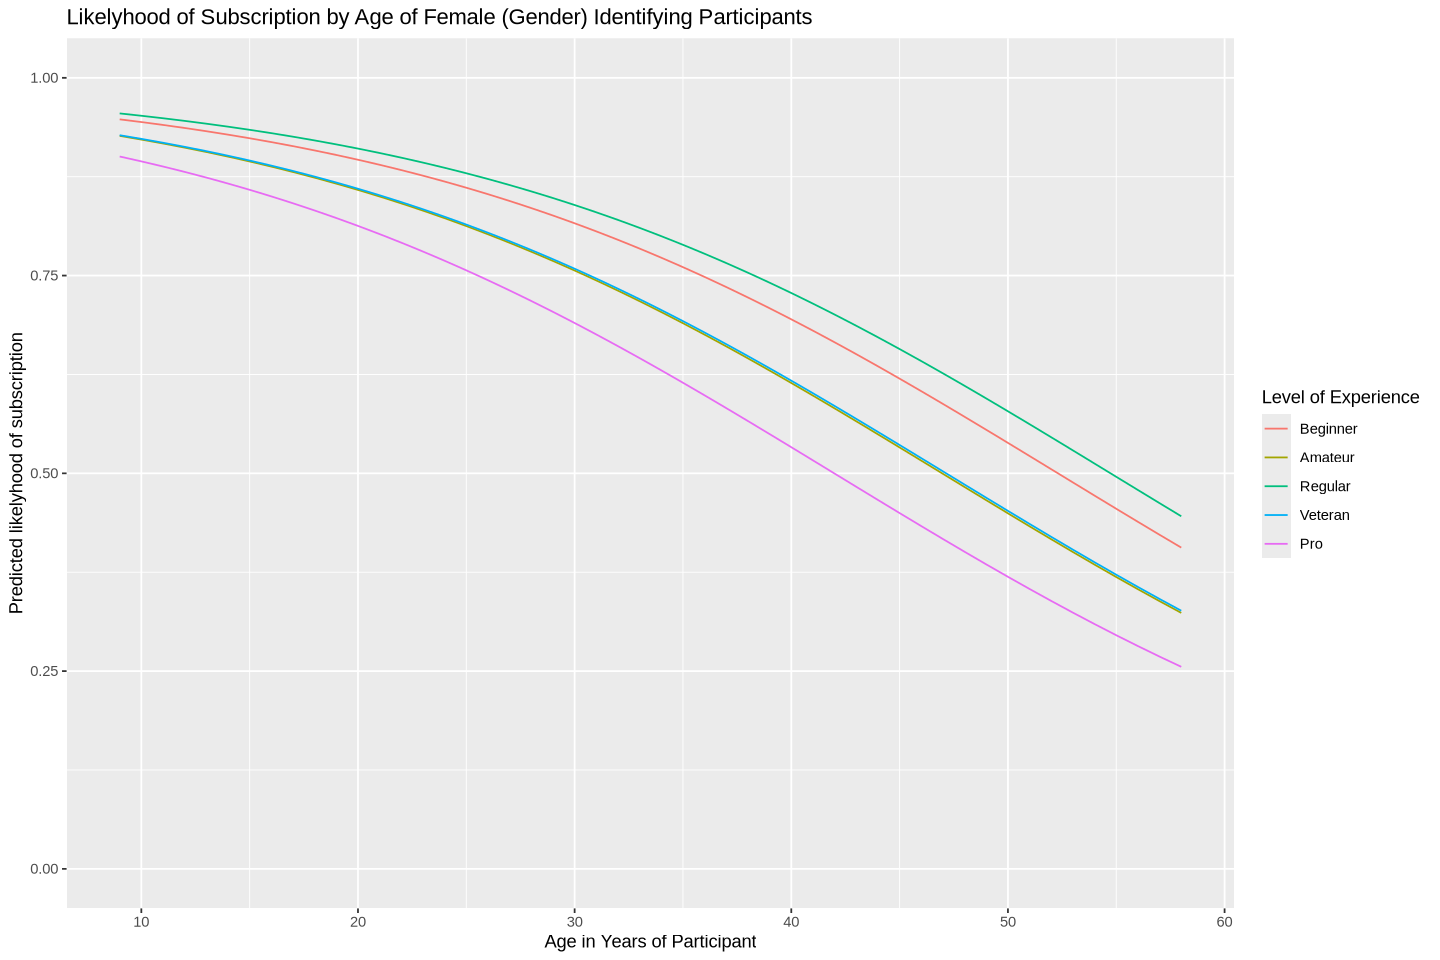

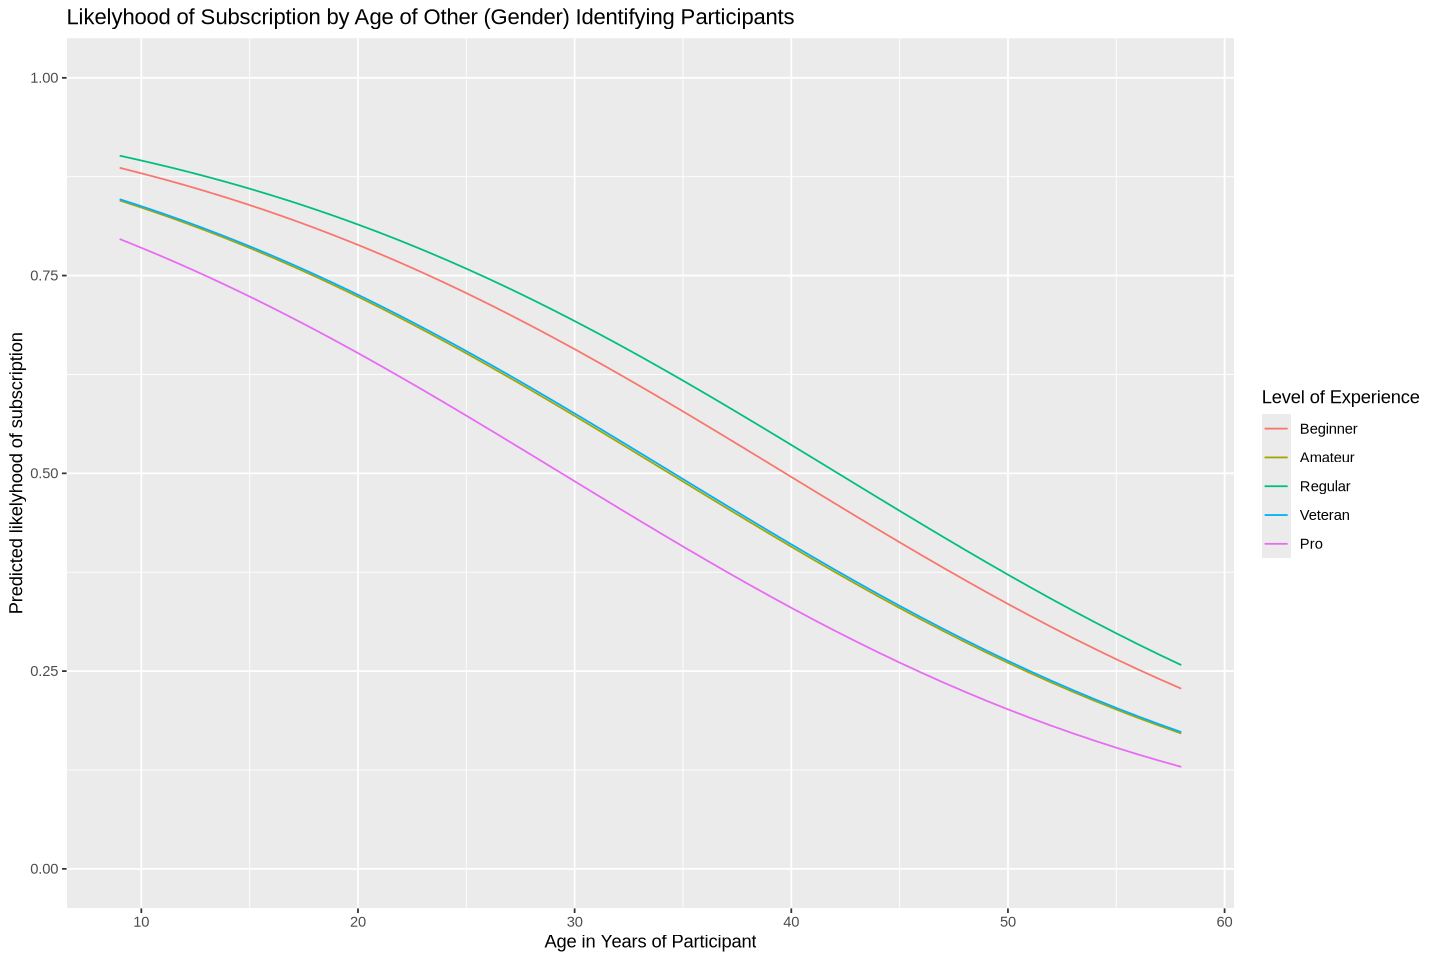

In [12]:
varying_age_data$predicted <- predict(log_model, varying_age_data, type = "response")
varying_age_data_male <- varying_age_data |> filter(gender3 == "Male")
varying_age_data_female <- varying_age_data |> filter(gender3 == "Female")
varying_age_data_other <- varying_age_data |> filter(gender3 == "Other")

varying_age_data_male_plot <- varying_age_data_male |> ggplot(aes(x=Age, y=predicted, color=experience)) +
    geom_line() +
    ylim(0, 1) +
    labs(x="Age in Years of Participant", y="Predicted likelyhood of subscription", title="Likelyhood of Subscription by Age of Male (Gender) Identifying Participants", color="Level of Experience")
varying_age_data_female_plot <- varying_age_data_female |> ggplot(aes(x=Age, y=predicted, color=experience)) +
    geom_line() +
    ylim(0, 1) +
    labs(x="Age in Years of Participant", y="Predicted likelyhood of subscription", title="Likelyhood of Subscription by Age of Female (Gender) Identifying Participants", color="Level of Experience")
varying_age_data_other_plot <- varying_age_data_other |> ggplot(aes(x=Age, y=predicted, color=experience)) +
    geom_line() +
    ylim(0, 1) +
    labs(x="Age in Years of Participant", y="Predicted likelyhood of subscription", title="Likelyhood of Subscription by Age of Other (Gender) Identifying Participants", color="Level of Experience")

options(repr.plot.width = 12, repr.plot.height = 8)

varying_age_data_male_plot
varying_age_data_female_plot
varying_age_data_other_plot

The veteran and amateur groups have roughly the same line across all categorical variable combinations and ages (while keeping played hours constant), which suggests that these two groups may not be considered that differently by the model. We also see that `Pro` players consistently have the lowest predicted rate of subscription compared to other experience groups, and `Regular` players have consistently the highest. Among the gender groups here, `Male` and `Female` indentifying participants have roughly equal rates while `Other` players have around 10% lower predicted subscription rate.

As the age gets higher, we see that the predicted likelyhood of subscription goes down in our model, though the rate at which it falls does slightly depend on the experience level and gender as we can see from the lines falling at different rates between the plots.

Now, let us look at our second quantitative varible: `played_hours`

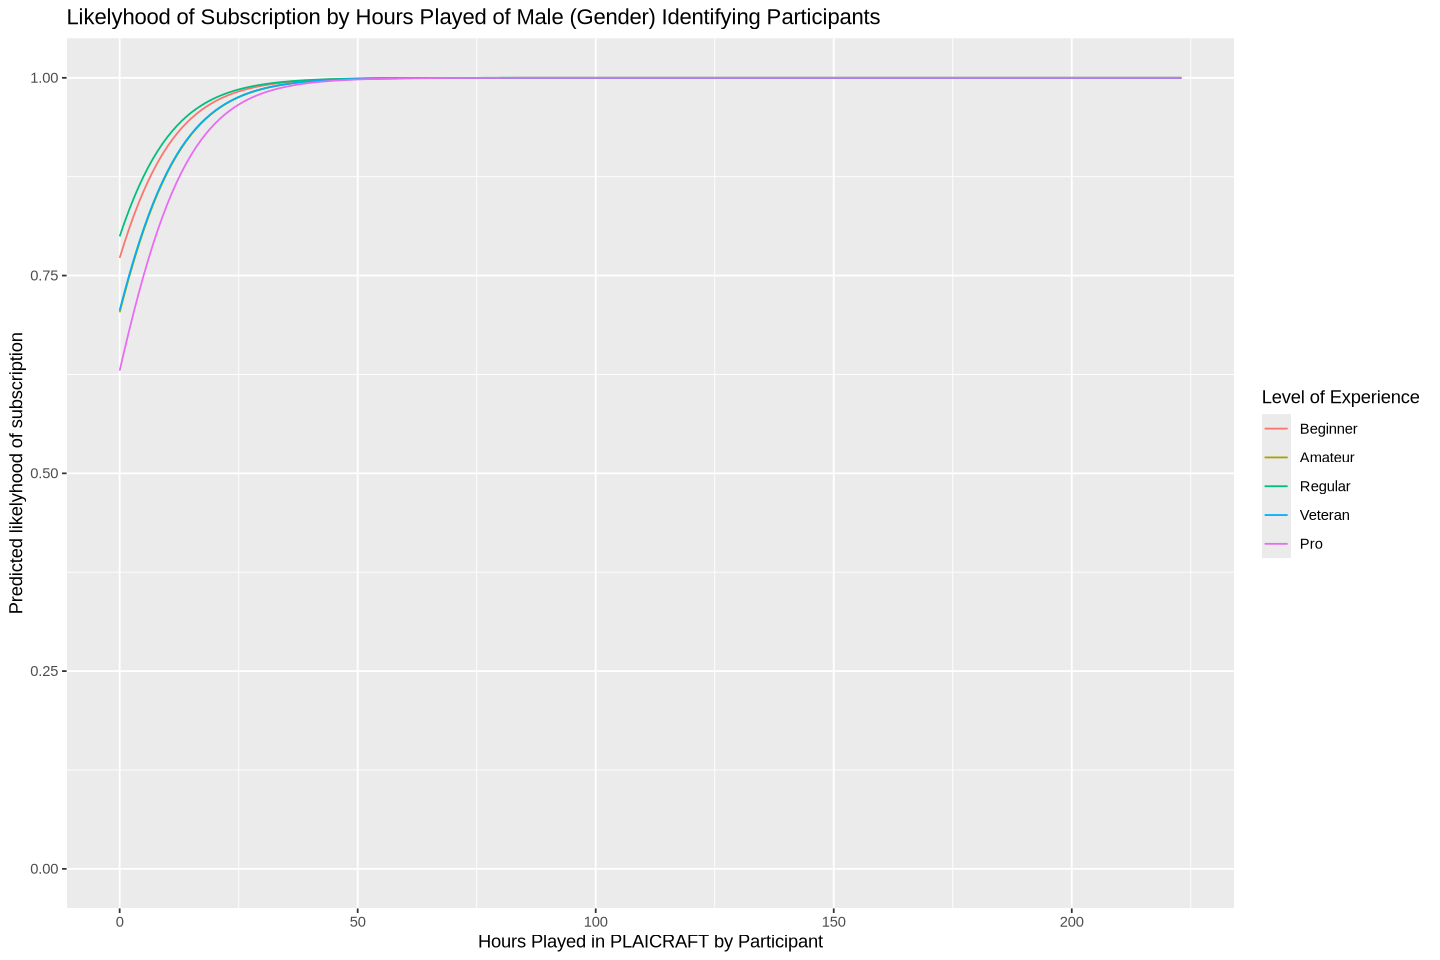

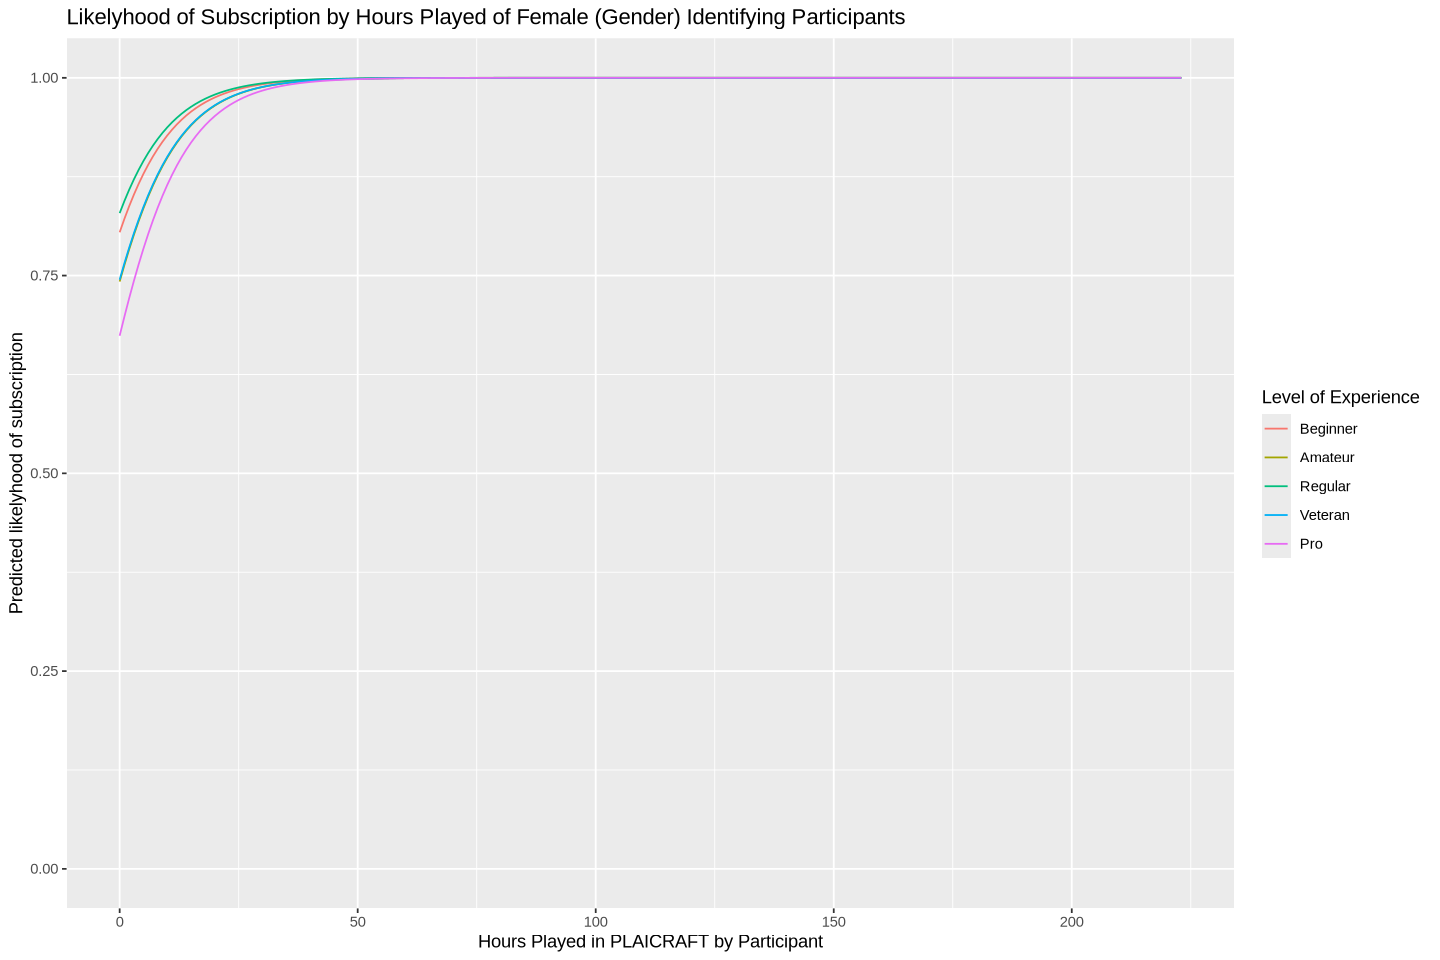

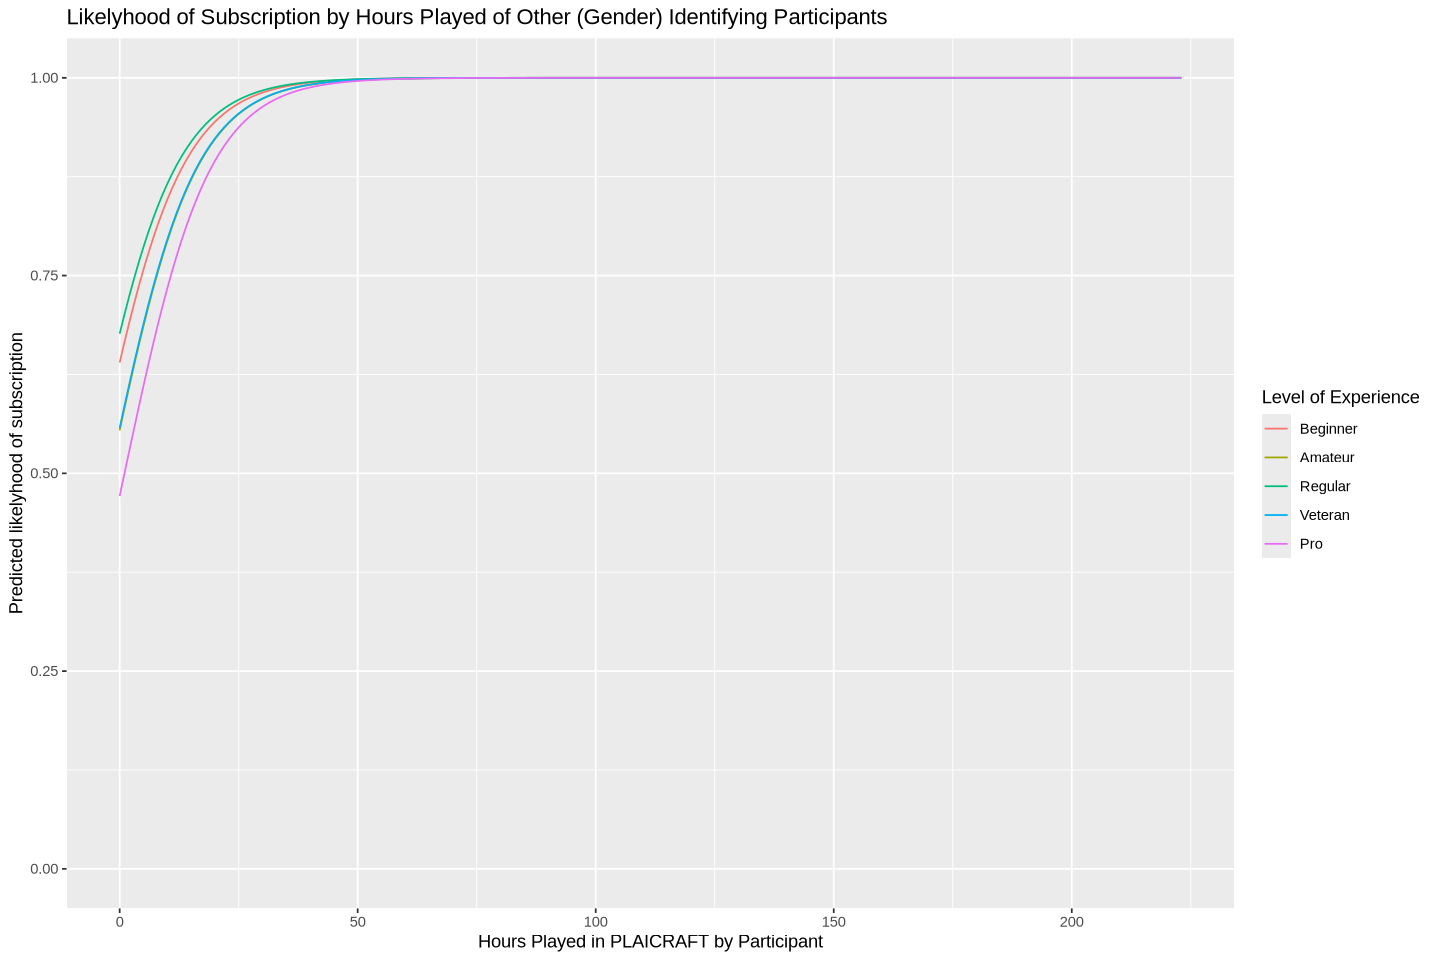

In [13]:
varying_hours_data$predicted <- predict(log_model, varying_hours_data, type = "response")
varying_hours_data_male <- varying_hours_data |> filter(gender3 == "Male")
varying_hours_data_female <- varying_hours_data |> filter(gender3 == "Female")
varying_hours_data_other <- varying_hours_data |> filter(gender3 == "Other")

varying_hours_data_male_plot <- varying_hours_data_male |> ggplot(aes(x=played_hours, y=predicted, color=experience)) +
    geom_line() +
    ylim(0, 1) +
    labs(x="Hours Played in PLAICRAFT by Participant", y="Predicted likelyhood of subscription", title="Likelyhood of Subscription by Hours Played of Male (Gender) Identifying Participants", color="Level of Experience")
varying_hours_data_female_plot <- varying_hours_data_female |> ggplot(aes(x=played_hours, y=predicted, color=experience)) +
    geom_line() +
    ylim(0, 1) +
    labs(x="Hours Played in PLAICRAFT by Participant", y="Predicted likelyhood of subscription", title="Likelyhood of Subscription by Hours Played of Female (Gender) Identifying Participants", color="Level of Experience")
varying_hours_data_other_plot <- varying_hours_data_other |> ggplot(aes(x=played_hours, y=predicted, color=experience)) +
    geom_line() +
    ylim(0, 1) +
    labs(x="Hours Played in PLAICRAFT by Participant", y="Predicted likelyhood of subscription", title="Likelyhood of Subscription by Hours Played of Other (Gender) Identifying Participants", color="Level of Experience")

varying_hours_data_male_plot
varying_hours_data_female_plot
varying_hours_data_other_plot

Here, we see a similar trend where the predicted subscription rate starts off lower for the `Other` gender group when compared to `Male` and `Female`, which start off around the same area. Also, we see that `Pro` players have the lowest predicted subscription rate while `Regular` players have the highest when looking at levels of experience.

Since hours played is a positive predictor, all predicted rates trend towards `1` when we increase the amount of time the player spends on the server while keeping everything else including age constant. Though all 5 levels of experience across all 3 gender groups seem to hit close to 100% predicted rate by the time we reach 50 hours played, this may be in part due to a lack of data from players that have played on the server for a long time.

# Discussion

> Original Question: Can the player's own Experience, Played Hours, Gender and Age predict whether the player will subscribe to the game newsletter?

The results we saw from the final model matched many correlations we had hypothesized during the data exploration phase. Below, we discuss how each of these elements appeared to impact the likelihood of subscription:

### Experience

During our exploratory analysis, we found that subscription rates across experience levels were highest among `Regular` players and lowest with `Veteran` and `Pro` players.

This is reflected in the final model, which consistently places `Regular` players as the most likely among all experience levels to subscribe, and `Pro` players as the least likely.

### Played Hours

We hypothesized that play time would have a positive correlation with subscription rate due to our initial data showing that all of our players with more than 10 hours belonged to the subscribed group. It was also reasoned that players spending more time on the game were more engaged with the activity, and thus had more reasons to subscribe.

In the model, the play-time is positively correlated with subscription likelihood and quickly trends towards 100% as we approach 50 hours of play-time. Due to a very limited set of players with play times past 50 hours, we take this fact with more scrutiny as this may not be representative of the true proportion. The positive correlation could be too strong due to a lack of players with lots of play time who are not subscribed.

### Gender

The data itself was overwhelmingly `Male` with `124/194` players identifying. There was an approximately even split of `37` `Female` to `33` `Other` identifying players. We initially did not suspect gender would play a large role in subscription status.

The final model did not show a significant difference between `Male` and `Female` predictions, with `Female` having a slightly higher rate of subscriptions. However, the `Other` gender group was consistently around 10% behind the other two groups when starting off.

### Age

We suspected that age would be negatively correlated with subscription rates, as we saw the proportion of subscribed players shrink for higher age groups. It was reasoned that the newsletter may appeal to younger players more, and thus we see a drop-off in subscription rates for older players.

The model itself also shows that across all combinations of experience and gender, age is negatively correlated with subscription rates with the highest predicted rates coming from our youngest players.


## Impact of Findings:
Our results help show which types of players are most likely to subscribe to the game newsletter and how the game team could improve engagement. Since `Regular` players were the most likely to subscribe, this suggests that **players who are still learning the game may be more open to receiving updates**. The strong positive link between `played hours` and `subscription` also shows that players who spend more time in the game are more engaged, which means **encouraging early play and keeping players active could increase subscriptions**.

`gender` did not play a major role, but the lower subscription rate in the `Other` gender group suggests that the newsletter content might not connect as well with this audience. `age` had a clearer effect since younger players were more likely to subscribe and interest dropped as age increased. This means the **newsletter might appeal more to younger players**, and the game team may want to adjust their messaging to better reach older players.

Overall, these findings can help guide future communication, improve targeting strategies, and show where more data might be needed to make stronger conclusions.

## Future questions for further studies.

These results also highlight several directions for future investigation. Because our model shows clear trends but is limited by sample size and the absence of additional behavioural variables, further studies could refine or expand upon these findings. For instance:

1. What other behavioural variables influence subscription?
+ Other game-related behaviours, such as session frequency, time-of-day activity, participation in events, or social interactions, may reveal stronger predictive patterns than demographics alone.
2. Does the timing of subscription matter?
+ A longitudinal dataset could help determine whether players tend to subscribe early or only after reaching certain engagement thresholds, and how this timing affects retention.
3. How does newsletter subscription affect future behaviour?
+ Future work could examine whether subscribing increases engagement, spending, or long-term retention, helping determine if the newsletter is a cause of increased activity or simply a marker of already-engaged players.
4. Are there important interaction effects not captured in our model?
+ Interactions like Age × Experience or Gender × Played Hours may reveal nuanced patterns that logistic regression without interaction terms may have missed.
5. Would alternative models improve predictive accuracy?
+ Exploring machine learning models such as random forests or gradient boosting could capture nonlinear relationships and provide stronger predictive performance.
6. How do different types of newsletter content perform?
+ If different editions or topics exist, a content-level analysis could reveal which types most effectively attract or retain subscribers.
7. Does community sentiment influence subscription?
+ Incorporating text data (e.g., chat, forums) could allow future researchers to analyze whether positive or negative player sentiment relates to the likelihood of subscribing.

These questions extend naturally from our analysis and could help clarify whether the patterns observed here generalize to broader or more diverse player populations.

# References

- For creating all possible combinations in the probability plots, we referenced the following [StackOverflow post discussing how to use `expand.grid`](https://stackoverflow.com/questions/66739100/how-to-use-expand-grid-to-create-all-possible-combinations-between-two-columns-i)
- Also for the probability plots, we referenced the following [StackOverflow post about how to work with glm models during prediction](https://stackoverflow.com/questions/47486589/what-is-the-difference-between-type-response-terms-and-link-in-predict-f) as we did not get a value between 0 and 1 initially like we had expected